# 플레이리스트 기반 노래 데이터 수집 함수

In [36]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup as bs
import json

import re
from tqdm import tqdm

In [37]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
#         !apt-get install fonts-nanum -qq  > /dev/null
#         !fc-cache -fv
        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

In [38]:
# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats("retina")

## 플레이리스트 단어 검색 메인

In [39]:
# 한글을 unicode hex로 변환.
def keyword_to_unicode(keyword: 'str') -> str:
    keyword.encode('utf-8')
    regex = re.compile(r'\\x')
    keyword_unicode = re.sub(regex, '%', str(keyword.encode('utf-8'))[2:-1]).upper()
    return keyword_unicode

# 사용 안함.
def get_playlst_main(keyword: 'str' = '행복') -> dict:
    playlist_url = "https://www.melon.com/dj/djfinder/djfinder_informCnt.json"
    # keyword to unicode
    keyword_unicode = keyword_to_unicode(keyword)
    # Headers information
    headers = {
        'Accept': 'application/json, text/javascript, */*; q=0.01',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'ko,en-US;q=0.9,en;q=0.8,zh;q=0.7',
        'Connection': 'keep-alive',
        'Content-Length': '81',
        'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
        'Host': 'www.melon.com',
        'Origin': 'https://www.melon.com',
        'Referer': f'https://www.melon.com/dj/djfinder/djfinder_inform.htm?djSearchType=T&djSearchKeyword={keyword_unicode}',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36',
        'X-Requested-With': 'XMLHttpRequest'
    }
    # payload information
    data = {
        'djSearchType':'T',
        'djSearchKeyword': keyword_unicode,
        'pagingFlag': 'Y',
        'tagSearchType': 'S'
    }
    # Request - Post
    response = requests.post(playlist_url, data, headers=headers)
    # json loads
    playlist_main = json.loads(response.text)
    return playlist_main

In [40]:
# 사용 예시
get_playlst_main('행복')

{'ORDERBY': 'POP',
 'djSearchKeyword': '#행복',
 'djSearchType': 'T',
 'pagingFlag': 'Y',
 'djPlylstList': [],
 'relationTagList': [],
 'djPlylstListTotCnt': 1042,
 'menuInfo': {'subMenu': 'DJ_FINDER',
  'mainMenu': 'DJ',
  'subMenuDpFlg': True,
  'menuTitle': '멜론DJ>DJ파인더>멜론',
  'menuLocation': '<a href="/dj/today/djtoday_list.htm" title="멜론DJ - 페이지 이동">멜론DJ</a> &gt; <strong><span class="none">현재 위치</span>DJ파인더</strong>'},
 'menuId': 67190101,
 'tagSearchType': 'S',
 'httpDomain': 'http://www.melon.com',
 'httpsDomain': 'https://www.melon.com',
 'staticDomain': 'https://static.melon.co.kr'}

## 관련 tag 수집

In [41]:
def get_related_tags(keyword: str = '행복') -> dict:
    related_tags = []
    result = {}
    playlist_tag_url = f'https://www.melon.com/dj/djfinder/djfinder_inform.htm?djSearchType=T&djSearchKeyword={keyword}'
    # Headers information    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36',
    }
    # Request - get
    response = requests.get(playlist_tag_url, headers = headers)
    html = response.text
    # parse text by beautifullsoup
    parse = bs(html, 'html.parser')
    # find imformations
    playlist_numbers_txt = parse.find_all("p", "text")
    related_tags_txt = parse.find_all("button", "tag_item")
    playlist_numbers = int(re.findall(r'[0-9]+', playlist_numbers_txt[0].text)[0])
    for idx in range(len(related_tags_txt)):
        related_tags.append(related_tags_txt[idx]['id'])
    # make return values
    result['keyword'] = keyword
    result['playlist_numbers'] = playlist_numbers
    result['related_tags_numbers'] = len(related_tags_txt)
    result['related_tags'] = related_tags
    
    return result

In [44]:
# 사용예시
a = get_related_tags('두근')

In [45]:
a['keyword'], a['playlist_numbers'], a['related_tags_numbers']

('두근', 369, 30)

In [46]:
print(a['related_tags'])

['설렘', '사랑', '봄', '달달', '기분전환', '설레임', '감성', '카페', '기분좋은', '썸', '인디', '휴식', '연애', '고백', '몽글몽글', '국내', '달달해', '분위기', '매장', '청춘', '커플', '힙합', '설레이는', '힐링', '스윗', '짝사랑', '두근두근', '명곡모음', '국힙', '셀렘']


### 기본 수집 태그 설정

In [47]:
인기테마 = ['기분전환', '감성', '힐링', '드라이브', '사랑', '추억', '이별', '여행', '여름', '휴식',
        '운동', '비오는날', '분위기', '위로', '트렌디', '공부', '몽환', 'ASMR', '카페', '클럽', '매장', 
        '노래방', '버스', '라운지', '한강', '집', '지하철'
       ]

In [48]:
인기장르 = ['발라드', '힙합', '인디', '댄스', '뉴에이지', '알앤비', '재즈', '클래식', '록', 
        '팝', 'OST', 'EDM', 'CCM', 'JPOP', '트로트', '월드뮤직', '블루스', '컨트리']

In [49]:
인기태그 = ['환상', '느긋한', '페스티벌', '여름밤', '싱잉랩', '생각', '흐림', '잔잔한', '설렘']

In [50]:
#major sentiment : happy, angry, peaceful, sad
감정태그1 = ['행복한', '화나는', '슬픈', '평온한']

In [51]:
#Excited, happy, contented, calm, fatigue, depressed, sad, disgusted, angry, nervous, fear, surprised
감정태그2 = ['설레는', '행복한', '만족하는', '침착한', '피로한', '우울한', '슬픈', '역겨운', '화난', '불안한', '두려운', '놀란']

In [52]:
total_tag_list = 인기장르 + 인기태그 + 감정태그1 + 감정태그2

In [53]:
print(total_tag_list)

['발라드', '힙합', '인디', '댄스', '뉴에이지', '알앤비', '재즈', '클래식', '록', '팝', 'OST', 'EDM', 'CCM', 'JPOP', '트로트', '월드뮤직', '블루스', '컨트리', '환상', '느긋한', '페스티벌', '여름밤', '싱잉랩', '생각', '흐림', '잔잔한', '설렘', '행복한', '화나는', '슬픈', '평온한', '설레는', '행복한', '만족하는', '침착한', '피로한', '우울한', '슬픈', '역겨운', '화난', '불안한', '두려운', '놀란']


In [17]:
# 사용예시
tag_df = pd.DataFrame(get_related_tags('행복'))

In [18]:
tag_df

,keyword,playlist_numbers,related_tags_numbers,related_tags
0,행복,1033,30,기분전환
1,행복,1033,30,사랑
2,행복,1033,30,감성
3,행복,1033,30,휴식
4,행복,1033,30,힐링
5,행복,1033,30,드라이브
6,행복,1033,30,설렘
7,행복,1033,30,카페
8,행복,1033,30,주말
9,행복,1033,30,신나는


In [56]:
# 모든 관련태그 검색 후 csv 파일로 저장하는 함수
def get_all_related_tags(keyword_list: list = total_tag_list):
    for idx, keyword in enumerate(tqdm(keyword_list)):
        if idx == 0:
            tag_df = pd.DataFrame(get_related_tags(keyword))
        else:
            tag_df = pd.concat([tag_df, pd.DataFrame(get_related_tags(keyword))])
    tag_df.to_csv(f'data/tags({len(keyword_list)}).csv', index=False)
    return tag_df

In [57]:
# 사용예시
tag_df = get_all_related_tags()

100%|██████████| 43/43 [00:13<00:00,  3.09it/s]


### 태그 분석

In [58]:
pd.read_csv('data/tags(43).csv')

,keyword,playlist_numbers,related_tags_numbers,related_tags
0,발라드,14214,30,감성
1,발라드,14214,30,잔잔한
2,발라드,14214,30,이별
3,발라드,14214,30,사랑
4,발라드,14214,30,기분전환
...,...,...,...,...
1028,슬픈,4461,30,힐링
1029,슬픈,4461,30,헤어짐
1030,슬픈,4461,30,팝송
1031,슬픈,4461,30,이별노래


In [62]:
tag_df.describe(include='object')

,keyword,related_tags
count,1033,1033
unique,33,325
top,슬픈,기분전환
freq,60,35


In [66]:
tag_df['related_tags'].nunique()

325

In [73]:
tag_df['related_tags'].value_counts()

기분전환    35
감성      33
힐링      26
휴식      26
잔잔한     25
        ..
송가인      1
영탁       1
트롯       1
정미애      1
우울할때     1
Name: related_tags, Length: 325, dtype: int64

In [80]:
related_tag_list = tag_df['related_tags'].unique().tolist()

In [82]:
print(related_tag_list)

['감성', '잔잔한', '이별', '사랑', '기분전환', '카페', '새벽', '추억', '겨울', '댄스', '휴식', '드라이브', '인디', '알앤비', '가을', '힙합', '밤', '슬픔', '케이팝', '힐링', '비오는날', '명곡', '최신가요', '매장음악', '오늘신곡모음', '위로', '가요', '회상', '신나는', '아이돌', '랩', '발라드', '국내힙합', 'HipHop', '트렌디', '국힙', '외힙', '감성힙합', '운동', '그루브', '스트레스', '팝', '클럽', '외국힙합', '여행', '비트', 'RnB', '인디음악', '봄', '어쿠스틱', '설렘', '여름', '포크', '분위기', '산책', '밴드', '걸그룹', 'EDM', 'kpop', 'Pop', '내적댄스', '헬스', '다이어트', '시원한', '파티', '청량', '피아노', '연주곡', '집중', '자장가', '공부', '독서', '편안한', '클래식', '아침', '북카페', '차분한', '배경음악', '명상', '숙면', '재즈', '잠들기전', '여유', '카페음악', '소울', '감각적인', '팝송', 'Jazz', '커피', '크리스마스', '매장', '뉴에이지', '보사노바', '주말', '캐롤', '태교', 'classic', '바이올린', '오케스트라', '첼로', '모닝콜', '락', '메탈', 'Rock', '록메탈', '해외록', '스쿨오브록', 'Metal', '락메탈', '헤비메탈', '국내록', '강렬한', '얼터너티브', '록발라드', '록명곡', '하드록', '취향저격', '드라마', '영화', '영화음악', '사운드트랙', '드라마ost', '애니메이션', 'bgm', '디즈니', '영화OST', '감동', '해외', '일렉트로니카', '일렉', '하우스', 'electronica', '일렉트로닉', '빌로우', '페스티벌', '불금', '이디엠', 'DJ', '영국', '찬양', '은혜', '감사', 'Pla

## 플레이리스트 수집기

In [74]:
 def get_playlist(keyword: str = '행복', page_no: int = 0, total: bool = True):
    # keyword to unicode
    keyword_unicode = keyword_to_unicode(keyword)
    # Headers information    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36',
    }
    titles = []
    # get all playlists
    if total == True:
        # get tag numbers
        playlist_tag_url = f'https://www.melon.com/dj/djfinder/djfinder_inform.htm?djSearchType=T&djSearchKeyword={keyword}'
        # Request - Post
        response_tag = requests.get(playlist_tag_url, headers=headers)
        # beautifull suop loads
        html_tag = response_tag.text
        # parse text by beautifullsoup
        parse_tag = bs(html_tag, 'lxml')
        # find imformations
        playlist_numbers_txt = parse_tag.find_all("p", "text")
        playlist_numbers = int(re.findall(r'[0-9]+', playlist_numbers_txt[0].text)[0])
        
        print(keyword,"키워드로 ",playlist_numbers,"전체 플레이리스트 수집을 시작합니다.")
        for page_no in range(playlist_numbers//20 + 1):
            startIndex = page_no*20 + 1
            playlist_url = f"https://www.melon.com/dj/djfinder/djfinder_inform.htm?startIndex={startIndex}&pageSize=20&djSearchType=T&djSearchKeyword=%23{keyword_unicode}&orderBy=POP&pagingFlag=Y&tagSearchType=S"
            # Request - Post
            response = requests.get(playlist_url, headers=headers)
            # beautifull suop loads
            html = response.text
            # parse text by beautifullsoup
            parse = bs(html, 'lxml')
            # find imformations
            titles_txt = parse.find_all("a", "ellipsis album_name")
            # titles extend
            titles.extend(titles_txt)
            print("*", end="")
    # get playlist page        
    else:
            print(keyword,"키워드로 ",page_no,"번 페이지 수집을 시작합니다.")
            startIndex = page_no*20 + 1
            playlist_url = f"https://www.melon.com/dj/djfinder/djfinder_inform.htm?startIndex={startIndex}&pageSize=20&djSearchType=T&djSearchKeyword=%23{keyword_unicode}&orderBy=POP&pagingFlag=Y&tagSearchType=S"
            # Request - Post
            response = requests.get(playlist_url, headers=headers)
            # beautifull suop loads
            html = response.text
            # parse text by beautifullsoup
            parse = bs(html, 'lxml')
            # find imformations
            titles_txt = parse.find_all("a", "ellipsis album_name")
            # titles extend
            titles.extend(titles_txt)
    
    # make dataframe 
    df = pd.DataFrame()
    plylstSeq_list = []
    title_list = []
    for title_no in range(len(titles)):
        plylstSeq_list.append(re.findall(r'[0-9][0-9][0-9]+', titles[title_no]['href'])[0])
        title_list.append(titles[title_no]['title'][:-5])
    
    df['plylstSeq'] = plylstSeq_list
    df['title'] = title_list
    df['tag'] = keyword
    print("")
    print("complete.")
    return df

In [34]:
# 사용예시
playlist_df = get_playlist(keyword='행복', page_no=0, total=True)

행복 키워드로  1033 전체 플레이리스트 수집을 시작합니다.
****************************************************
complete.


In [35]:
playlist_df

,plylstSeq,title,tag
0,495119848,나도 모르게 미소가 지어지는 싱그러운 여름날의 JAZZ,행복
1,444702404,언제 들어도 기분 좋아지는 멜로디의 POP,행복
2,504995932,새벽 비행기에서 듣고 싶은 몽글몽글한 감성 POP,행복
3,511123665,"여유로운 아침, 따스한 햇빛이 기분 좋게 나를 깨울 때",행복
4,492052479,몽글몽글 첫사랑의 기억 -`♡´- Korea High Teen ✧,행복
...,...,...,...
1028,512649653,카페에서 들으면 잠시 감상하게 되는 노래,행복
1029,505616635,듣기만 해도 기분 up되는 걸그룹 모음,행복
1030,505287701,"집콕 주말, 여유롭게 듣기 좋은 ᴘᴏᴘ",행복
1031,511038158,행복지수 UP! 피곤한 발걸음이 가벼워지는 기분 좋은 디즈니 OST ◡̎,행복


In [169]:
# 태그 리스트를 받아서 모든 플레이리스트를 csv 형태로 저장해주는 함수
def get_all_playlist(keyword_list: list = ['행복','사랑','슬픔']):
    playlist_df = pd.DataFrame()
    for idx, keyword in enumerate(tqdm(keyword_list)):
        print(idx, keyword)
        if(idx == 0):
            playlist_df = get_playlist(keyword, 0, True)
        else:
            playlist_df = pd.concat([playlist_df, get_playlist(keyword, 0, True)])
    playlist_df.to_csv(f'data/playlist({len(keyword_list)}).csv', index=False)
    return playlist_df

In [84]:
all_playlist_df = get_all_playlist(related_tag_list)

  0%|          | 0/325 [00:00<?, ?it/s]

0 감성
감성 키워드로  19395 전체 플레이리스트 수집을 시작합니다.
***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  0%|          | 1/325 [02:11<11:48:48, 131.26s/it]

**
complete.
1 잔잔한
잔잔한 키워드로  15523 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  1%|          | 2/325 [04:27<12:03:32, 134.40s/it]

*
complete.
2 이별
이별 키워드로  6123 전체 플레이리스트 수집을 시작합니다.
******************************************************************************************************************************************************************************************************************************************************************************************************************

  1%|          | 3/325 [05:24<8:51:02, 98.95s/it]  

*
complete.
3 사랑
사랑 키워드로  10985 전체 플레이리스트 수집을 시작합니다.
*********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  1%|          | 4/325 [07:24<9:33:42, 107.24s/it]

*
complete.
4 기분전환
기분전환 키워드로  25073 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  2%|▏         | 5/325 [10:23<11:50:02, 133.13s/it]

*
complete.
5 카페
카페 키워드로  11671 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  2%|▏         | 6/325 [11:55<10:33:00, 119.06s/it]

*
complete.
6 새벽
새벽 키워드로  11083 전체 플레이리스트 수집을 시작합니다.
***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
complete.


  2%|▏         | 7/325 [13:29<9:48:07, 110.97s/it] 

7 추억
추억 키워드로  8520 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  2%|▏         | 8/325 [14:50<8:55:07, 101.29s/it]

**
complete.
8 겨울
겨울 키워드로  5246 전체 플레이리스트 수집을 시작합니다.
**********************************************************************************************************************************************************************************************************************************************************************

  3%|▎         | 9/325 [15:34<7:19:21, 83.42s/it] 

*
complete.
9 댄스
댄스 키워드로  5649 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************************************************************

  3%|▎         | 10/325 [16:20<6:16:48, 71.77s/it]

**
complete.
10 휴식
휴식 키워드로  16161 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  3%|▎         | 11/325 [18:08<7:13:35, 82.85s/it]

*
complete.
11 드라이브
드라이브 키워드로  16428 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  4%|▎         | 12/325 [19:33<7:16:02, 83.59s/it]

*
complete.
12 인디
인디 키워드로  6182 전체 플레이리스트 수집을 시작합니다.
**********************************************************************************************************************************************************************************************************************************************************************************************************************

  4%|▍         | 13/325 [20:10<6:02:11, 69.65s/it]


complete.
13 알앤비
알앤비 키워드로  6955 전체 플레이리스트 수집을 시작합니다.
***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  4%|▍         | 14/325 [20:54<5:19:44, 61.69s/it]

*
complete.
14 가을
가을 키워드로  5138 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************************************************************************************************************

  5%|▍         | 15/325 [21:24<4:30:38, 52.38s/it]

*
complete.
15 힙합
힙합 키워드로  10345 전체 플레이리스트 수집을 시작합니다.
************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  5%|▍         | 16/325 [22:28<4:47:05, 55.75s/it]

**
complete.
16 밤
밤 키워드로  9640 전체 플레이리스트 수집을 시작합니다.
*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  5%|▌         | 17/325 [23:28<4:52:35, 57.00s/it]

**
complete.
17 슬픔
슬픔 키워드로  4461 전체 플레이리스트 수집을 시작합니다.
******************************************************************************************************************************************************************************************************************************

  6%|▌         | 18/325 [23:55<4:05:25, 47.96s/it]

**
complete.
18 케이팝
케이팝 키워드로  2820 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************

  6%|▌         | 19/325 [24:13<3:18:38, 38.95s/it]

***
complete.
19 힐링
힐링 키워드로  12890 전체 플레이리스트 수집을 시작합니다.
*********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  6%|▌         | 20/325 [25:24<4:06:34, 48.51s/it]


complete.
20 비오는날
비오는날 키워드로  3940 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************

  6%|▋         | 21/325 [25:47<3:27:45, 41.00s/it]

*
complete.
21 명곡
명곡 키워드로  4011 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************************************************************************

  7%|▋         | 22/325 [26:12<3:03:05, 36.25s/it]

**
complete.
22 최신가요
최신가요 키워드로  435 전체 플레이리스트 수집을 시작합니다.
*********************

  7%|▋         | 23/325 [26:15<2:11:37, 26.15s/it]

*
complete.
23 매장음악
매장음악 키워드로  5950 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************************************************************************************************************************************************************************************************************

  7%|▋         | 24/325 [26:51<2:25:47, 29.06s/it]

**
complete.
24 오늘신곡모음
오늘신곡모음 키워드로  376 전체 플레이리스트 수집을 시작합니다.
*****************

  8%|▊         | 25/325 [26:53<1:45:18, 21.06s/it]

**
complete.
25 위로
위로 키워드로  3233 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************

  8%|▊         | 26/325 [27:14<1:43:55, 20.86s/it]

**
complete.
26 가요
가요 키워드로  1539 전체 플레이리스트 수집을 시작합니다.
****************************************************************************

  8%|▊         | 27/325 [27:23<1:25:56, 17.30s/it]

*
complete.
27 회상
회상 키워드로  5336 전체 플레이리스트 수집을 시작합니다.
**************************************************************************************************************************************************************************************************************************************************************************

  9%|▊         | 28/325 [27:54<1:46:46, 21.57s/it]

*
complete.
28 신나는
신나는 키워드로  11420 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

  9%|▉         | 29/325 [29:02<2:55:27, 35.56s/it]


complete.
29 아이돌
아이돌 키워드로  2889 전체 플레이리스트 수집을 시작합니다.
************************************************************************************************************************************************

  9%|▉         | 30/325 [29:20<2:27:51, 30.07s/it]

*
complete.
30 랩
랩 키워드로  4663 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************************************************************************************

 10%|▉         | 31/325 [29:47<2:24:04, 29.40s/it]

**
complete.
31 발라드
발라드 키워드로  14214 전체 플레이리스트 수집을 시작합니다.
***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 10%|▉         | 32/325 [31:39<4:24:08, 54.09s/it]


complete.
32 국내힙합
국내힙합 키워드로  1673 전체 플레이리스트 수집을 시작합니다.
**********************************************************************************

 10%|█         | 33/325 [31:57<3:29:54, 43.13s/it]

**
complete.
33 HipHop
HipHop 키워드로  10345 전체 플레이리스트 수집을 시작합니다.
*************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 10%|█         | 34/325 [33:25<4:35:25, 56.79s/it]

*
complete.
34 트렌디
트렌디 키워드로  3033 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************************************************************
complete.


 11%|█         | 35/325 [33:52<3:51:02, 47.80s/it]

35 국힙
국힙 키워드로  1673 전체 플레이리스트 수집을 시작합니다.
************************************************************************************

 11%|█         | 36/325 [34:10<3:07:21, 38.90s/it]


complete.
36 외힙
외힙 키워드로  908 전체 플레이리스트 수집을 시작합니다.
********************************************

 11%|█▏        | 37/325 [34:20<2:24:52, 30.18s/it]

**
complete.
37 감성힙합
감성힙합 키워드로  1370 전체 플레이리스트 수집을 시작합니다.
********************************************************************

 12%|█▏        | 38/325 [34:34<2:00:44, 25.24s/it]

*
complete.
38 운동
운동 키워드로  3954 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************************************************

 12%|█▏        | 39/325 [35:06<2:10:23, 27.36s/it]

**
complete.
39 그루브
그루브 키워드로  2553 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************

 12%|█▏        | 40/325 [35:26<1:59:54, 25.24s/it]

*
complete.
40 스트레스
스트레스 키워드로  4789 전체 플레이리스트 수집을 시작합니다.
**********************************************************************************************************************************************************************************************************************************************

 13%|█▎        | 41/325 [36:08<2:23:25, 30.30s/it]

**
complete.
41 팝
팝 키워드로  15180 전체 플레이리스트 수집을 시작합니다.
**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 13%|█▎        | 42/325 [38:01<4:18:53, 54.89s/it]

**
complete.
42 클럽
클럽 키워드로  2230 전체 플레이리스트 수집을 시작합니다.
**************************************************************************************************************

 13%|█▎        | 43/325 [38:26<3:35:42, 45.90s/it]

**
complete.
43 외국힙합
외국힙합 키워드로  908 전체 플레이리스트 수집을 시작합니다.
********************************************

 14%|█▎        | 44/325 [38:34<2:42:38, 34.73s/it]

**
complete.
44 여행
여행 키워드로  7321 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 14%|█▍        | 45/325 [39:38<3:22:01, 43.29s/it]

**
complete.
45 비트
비트 키워드로  806 전체 플레이리스트 수집을 시작합니다.
****************************************

 14%|█▍        | 46/325 [39:44<2:29:50, 32.23s/it]

*
complete.
46 RnB
RnB 키워드로  6955 전체 플레이리스트 수집을 시작합니다.
***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 14%|█▍        | 47/325 [40:47<3:12:22, 41.52s/it]

*
complete.
47 인디음악
인디음악 키워드로  1382 전체 플레이리스트 수집을 시작합니다.
*********************************************************************

 15%|█▍        | 48/325 [40:59<2:30:54, 32.69s/it]

*
complete.
48 봄
봄 키워드로  4535 전체 플레이리스트 수집을 시작합니다.
**********************************************************************************************************************************************************************************************************************************

 15%|█▌        | 49/325 [41:37<2:37:47, 34.30s/it]

*
complete.
49 어쿠스틱
어쿠스틱 키워드로  1427 전체 플레이리스트 수집을 시작합니다.
**********************************************************************

 15%|█▌        | 50/325 [41:50<2:07:21, 27.79s/it]

**
complete.
50 설렘
설렘 키워드로  6737 전체 플레이리스트 수집을 시작합니다.
***********************************************************************************************************************************************************************************************************************************************************************************************************************************************

 16%|█▌        | 51/325 [42:48<2:47:51, 36.76s/it]

**
complete.
51 여름
여름 키워드로  6394 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************************************************************************************************************************************************************************************************

 16%|█▌        | 52/325 [43:45<3:15:59, 43.08s/it]

*
complete.
52 포크
포크 키워드로  635 전체 플레이리스트 수집을 시작합니다.
*******************************

 16%|█▋        | 53/325 [43:51<2:23:44, 31.71s/it]

*
complete.
53 분위기
분위기 키워드로  3931 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************************************************

 17%|█▋        | 54/325 [44:22<2:22:56, 31.65s/it]

*
complete.
54 산책
산책 키워드로  3707 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************

 17%|█▋        | 55/325 [44:56<2:25:45, 32.39s/it]

*
complete.
55 밴드
밴드 키워드로  774 전체 플레이리스트 수집을 시작합니다.
***************************************
complete.


 17%|█▋        | 56/325 [45:02<1:49:36, 24.45s/it]

56 걸그룹
걸그룹 키워드로  926 전체 플레이리스트 수집을 시작합니다.
**********************************************

 18%|█▊        | 57/325 [45:13<1:30:17, 20.21s/it]

*
complete.
57 EDM
EDM 키워드로  2323 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************************

 18%|█▊        | 58/325 [45:34<1:32:11, 20.72s/it]

*
complete.
58 kpop
kpop 키워드로  2820 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************************************************

 18%|█▊        | 59/325 [45:59<1:36:27, 21.76s/it]

**
complete.
59 Pop
Pop 키워드로  15180 전체 플레이리스트 수집을 시작합니다.
***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 18%|█▊        | 60/325 [48:40<4:41:13, 63.67s/it]

*
complete.
60 내적댄스
내적댄스 키워드로  734 전체 플레이리스트 수집을 시작합니다.
***********************************

 19%|█▉        | 61/325 [48:47<3:24:46, 46.54s/it]

**
complete.
61 헬스
헬스 키워드로  732 전체 플레이리스트 수집을 시작합니다.
************************************

 19%|█▉        | 62/325 [48:55<2:33:29, 35.02s/it]

*
complete.
62 다이어트
다이어트 키워드로  477 전체 플레이리스트 수집을 시작합니다.
**********************

 19%|█▉        | 63/325 [49:01<1:55:08, 26.37s/it]

**
complete.
63 시원한
시원한 키워드로  1607 전체 플레이리스트 수집을 시작합니다.
********************************************************************************

 20%|█▉        | 64/325 [49:23<1:49:40, 25.21s/it]

*
complete.
64 파티
파티 키워드로  826 전체 플레이리스트 수집을 시작합니다.
******************************************

 20%|██        | 65/325 [49:36<1:32:35, 21.37s/it]


complete.
65 청량
청량 키워드로  1894 전체 플레이리스트 수집을 시작합니다.
**********************************************************************************************

 20%|██        | 66/325 [50:07<1:45:14, 24.38s/it]

*
complete.
66 피아노
피아노 키워드로  2769 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************

 21%|██        | 67/325 [50:39<1:54:42, 26.68s/it]


complete.
67 연주곡
연주곡 키워드로  2420 전체 플레이리스트 수집을 시작합니다.
*************************************************************************************************************************

 21%|██        | 68/325 [51:04<1:51:13, 25.97s/it]

*
complete.
68 집중
집중 키워드로  1600 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************

 21%|██        | 69/325 [51:17<1:34:36, 22.18s/it]

**
complete.
69 자장가
자장가 키워드로  1384 전체 플레이리스트 수집을 시작합니다.
********************************************************************

 22%|██▏       | 70/325 [51:29<1:21:00, 19.06s/it]

**
complete.
70 공부
공부 키워드로  1834 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************

 22%|██▏       | 71/325 [51:43<1:14:30, 17.60s/it]

*
complete.
71 독서
독서 키워드로  1219 전체 플레이리스트 수집을 시작합니다.
*************************************************************
complete.


 22%|██▏       | 72/325 [51:53<1:04:53, 15.39s/it]

72 편안한
편안한 키워드로  2073 전체 플레이리스트 수집을 시작합니다.
******************************************************************************************************

 22%|██▏       | 73/325 [52:11<1:07:37, 16.10s/it]

**
complete.
73 클래식
클래식 키워드로  2941 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************
complete.


 23%|██▎       | 74/325 [52:37<1:19:24, 18.98s/it]

74 아침
아침 키워드로  1682 전체 플레이리스트 수집을 시작합니다.
***********************************************************************************

 23%|██▎       | 75/325 [52:53<1:15:34, 18.14s/it]

**
complete.
75 북카페
북카페 키워드로  377 전체 플레이리스트 수집을 시작합니다.
*******************
complete.


 23%|██▎       | 76/325 [52:56<56:47, 13.68s/it]  

76 차분한
차분한 키워드로  978 전체 플레이리스트 수집을 시작합니다.
************************************************

 24%|██▎       | 77/325 [53:03<48:41, 11.78s/it]

*
complete.
77 배경음악
배경음악 키워드로  1320 전체 플레이리스트 수집을 시작합니다.
******************************************************************

 24%|██▍       | 78/325 [53:14<47:05, 11.44s/it]

*
complete.
78 명상
명상 키워드로  427 전체 플레이리스트 수집을 시작합니다.
********************

 24%|██▍       | 79/325 [53:17<36:55,  9.00s/it]

**
complete.
79 숙면
숙면 키워드로  551 전체 플레이리스트 수집을 시작합니다.
****************************
complete.


 25%|██▍       | 80/325 [53:22<31:35,  7.74s/it]

80 재즈
재즈 키워드로  4672 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************

 25%|██▍       | 81/325 [54:00<1:08:44, 16.90s/it]

*
complete.
81 잠들기전
잠들기전 키워드로  949 전체 플레이리스트 수집을 시작합니다.
**********************************************

 25%|██▌       | 82/325 [54:09<58:34, 14.46s/it]  

**
complete.
82 여유
여유 키워드로  1290 전체 플레이리스트 수집을 시작합니다.
***************************************************************

 26%|██▌       | 83/325 [54:20<53:31, 13.27s/it]

**
complete.
83 카페음악
카페음악 키워드로  1029 전체 플레이리스트 수집을 시작합니다.
**************************************************

 26%|██▌       | 84/325 [54:29<48:02, 11.96s/it]

**
complete.
84 소울
소울 키워드로  2950 전체 플레이리스트 수집을 시작합니다.
**************************************************************************************************************************************************

 26%|██▌       | 85/325 [54:52<1:01:19, 15.33s/it]

**
complete.
85 감각적인
감각적인 키워드로  1665 전체 플레이리스트 수집을 시작합니다.
***********************************************************************************

 26%|██▋       | 86/325 [55:07<1:00:55, 15.30s/it]

*
complete.
86 팝송
팝송 키워드로  4644 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************************************************************************************************************************************************************

 27%|██▋       | 87/325 [55:45<1:27:13, 21.99s/it]

*
complete.
87 Jazz
Jazz 키워드로  4672 전체 플레이리스트 수집을 시작합니다.
******************************************************************************************************************************************************************************************************************************************
complete.


 27%|██▋       | 88/325 [56:27<1:51:09, 28.14s/it]

88 커피
커피 키워드로  1534 전체 플레이리스트 수집을 시작합니다.
****************************************************************************

 27%|██▋       | 89/325 [56:41<1:34:16, 23.97s/it]

*
complete.
89 크리스마스
크리스마스 키워드로  1963 전체 플레이리스트 수집을 시작합니다.
*************************************************************************************************

 28%|██▊       | 90/325 [57:00<1:27:47, 22.42s/it]

**
complete.
90 매장
매장 키워드로  1639 전체 플레이리스트 수집을 시작합니다.
*********************************************************************************

 28%|██▊       | 91/325 [57:13<1:16:19, 19.57s/it]

*
complete.
91 뉴에이지
뉴에이지 키워드로  4290 전체 플레이리스트 수집을 시작합니다.
*********************************************************************************************************************************************************************************************************************

 28%|██▊       | 92/325 [57:48<1:33:41, 24.13s/it]

**
complete.
92 보사노바
보사노바 키워드로  229 전체 플레이리스트 수집을 시작합니다.
**********

 29%|██▊       | 93/325 [57:50<1:07:46, 17.53s/it]

**
complete.
93 주말
주말 키워드로  2084 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************************

 29%|██▉       | 94/325 [58:09<1:09:17, 18.00s/it]

*
complete.
94 캐롤
캐롤 키워드로  1288 전체 플레이리스트 수집을 시작합니다.
****************************************************************

 29%|██▉       | 95/325 [58:22<1:03:35, 16.59s/it]

*
complete.
95 태교
태교 키워드로  349 전체 플레이리스트 수집을 시작합니다.
****************

 30%|██▉       | 96/325 [58:28<50:17, 13.17s/it]  

**
complete.
96 classic
classic 키워드로  2941 전체 플레이리스트 수집을 시작합니다.
***************************************************************************************************************************************************

 30%|██▉       | 97/325 [58:54<1:04:40, 17.02s/it]

*
complete.
97 바이올린
바이올린 키워드로  150 전체 플레이리스트 수집을 시작합니다.
*******

 30%|███       | 98/325 [58:55<46:40, 12.34s/it]  

*
complete.
98 오케스트라
오케스트라 키워드로  169 전체 플레이리스트 수집을 시작합니다.
********

 30%|███       | 99/325 [58:57<34:39,  9.20s/it]

*
complete.
99 첼로
첼로 키워드로  112 전체 플레이리스트 수집을 시작합니다.
*****

 31%|███       | 100/325 [58:58<25:42,  6.85s/it]

*
complete.
100 모닝콜
모닝콜 키워드로  490 전체 플레이리스트 수집을 시작합니다.
************************

 31%|███       | 101/325 [59:08<28:36,  7.66s/it]

*
complete.
101 락
락 키워드로  6764 전체 플레이리스트 수집을 시작합니다.
**************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 31%|███▏      | 102/325 [1:00:02<1:20:07, 21.56s/it]

*
complete.
102 메탈
메탈 키워드로  604 전체 플레이리스트 수집을 시작합니다.
******************************

 32%|███▏      | 103/325 [1:00:07<1:01:12, 16.54s/it]

*
complete.
103 Rock
Rock 키워드로  6764 전체 플레이리스트 수집을 시작합니다.
*************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 32%|███▏      | 104/325 [1:00:47<1:27:22, 23.72s/it]

**
complete.
104 록메탈
록메탈 키워드로  268 전체 플레이리스트 수집을 시작합니다.
************

 32%|███▏      | 105/325 [1:00:50<1:03:50, 17.41s/it]

**
complete.
105 해외록
해외록 키워드로  163 전체 플레이리스트 수집을 시작합니다.
*******

 33%|███▎      | 106/325 [1:00:51<45:57, 12.59s/it]  

**
complete.
106 스쿨오브록
스쿨오브록 키워드로  95 전체 플레이리스트 수집을 시작합니다.
***

 33%|███▎      | 107/325 [1:00:52<32:52,  9.05s/it]

**
complete.
107 Metal
Metal 키워드로  604 전체 플레이리스트 수집을 시작합니다.
*****************************

 33%|███▎      | 108/325 [1:00:56<26:58,  7.46s/it]

**
complete.
108 락메탈
락메탈 키워드로  268 전체 플레이리스트 수집을 시작합니다.
************

 34%|███▎      | 109/325 [1:00:57<20:38,  5.73s/it]

**
complete.
109 헤비메탈
헤비메탈 키워드로  116 전체 플레이리스트 수집을 시작합니다.
****

 34%|███▍      | 110/325 [1:00:58<15:18,  4.27s/it]

**
complete.
110 국내록
국내록 키워드로  144 전체 플레이리스트 수집을 시작합니다.
******

 34%|███▍      | 111/325 [1:00:59<11:45,  3.29s/it]

**
complete.
111 강렬한
강렬한 키워드로  180 전체 플레이리스트 수집을 시작합니다.
*******

 34%|███▍      | 112/325 [1:01:01<09:48,  2.76s/it]

***
complete.
112 얼터너티브
얼터너티브 키워드로  254 전체 플레이리스트 수집을 시작합니다.
************

 35%|███▍      | 113/325 [1:01:02<08:28,  2.40s/it]

*
complete.
113 록발라드
록발라드 키워드로  201 전체 플레이리스트 수집을 시작합니다.
*********

 35%|███▌      | 114/325 [1:01:04<07:24,  2.11s/it]

**
complete.
114 록명곡
록명곡 키워드로  59 전체 플레이리스트 수집을 시작합니다.
*

 35%|███▌      | 115/325 [1:01:04<05:48,  1.66s/it]

**
complete.
115 하드록
하드록 키워드로  99 전체 플레이리스트 수집을 시작합니다.
****

 36%|███▌      | 116/325 [1:01:06<05:21,  1.54s/it]

*
complete.
116 취향저격
취향저격 키워드로  1573 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************

 36%|███▌      | 117/325 [1:01:16<14:01,  4.05s/it]


complete.
117 드라마
드라마 키워드로  807 전체 플레이리스트 수집을 시작합니다.
***************************************

 36%|███▋      | 118/325 [1:01:21<15:03,  4.37s/it]

**
complete.
118 영화
영화 키워드로  746 전체 플레이리스트 수집을 시작합니다.
***********************************

 37%|███▋      | 119/325 [1:01:25<15:29,  4.51s/it]

***
complete.
119 영화음악
영화음악 키워드로  403 전체 플레이리스트 수집을 시작합니다.
*******************

 37%|███▋      | 120/325 [1:01:28<13:28,  3.94s/it]

**
complete.
120 사운드트랙
사운드트랙 키워드로  202 전체 플레이리스트 수집을 시작합니다.
*********

 37%|███▋      | 121/325 [1:01:29<10:41,  3.15s/it]

**
complete.
121 드라마ost
드라마ost 키워드로  386 전체 플레이리스트 수집을 시작합니다.
*******************

 38%|███▊      | 122/325 [1:01:32<09:59,  2.95s/it]

*
complete.
122 애니메이션
애니메이션 키워드로  322 전체 플레이리스트 수집을 시작합니다.
***************

 38%|███▊      | 123/325 [1:01:34<09:01,  2.68s/it]

**
complete.
123 bgm
bgm 키워드로  1320 전체 플레이리스트 수집을 시작합니다.
*****************************************************************

 38%|███▊      | 124/325 [1:01:43<14:56,  4.46s/it]

**
complete.
124 디즈니
디즈니 키워드로  247 전체 플레이리스트 수집을 시작합니다.
*************

 38%|███▊      | 125/325 [1:01:44<11:57,  3.59s/it]


complete.
125 영화OST
영화OST 키워드로  221 전체 플레이리스트 수집을 시작합니다.
***********

 39%|███▉      | 126/325 [1:01:46<09:51,  2.97s/it]

*
complete.
126 감동
감동 키워드로  427 전체 플레이리스트 수집을 시작합니다.
*******************

 39%|███▉      | 127/325 [1:01:48<09:39,  2.93s/it]

***
complete.
127 해외
해외 키워드로  466 전체 플레이리스트 수집을 시작합니다.
************************
complete.


 39%|███▉      | 128/325 [1:01:51<09:21,  2.85s/it]

128 일렉트로니카
일렉트로니카 키워드로  4696 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************

 40%|███▉      | 129/325 [1:02:19<34:11, 10.47s/it]

**
complete.
129 일렉
일렉 키워드로  4696 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************************************************************************************************************

 40%|████      | 130/325 [1:02:48<51:58, 15.99s/it]


complete.
130 하우스
하우스 키워드로  652 전체 플레이리스트 수집을 시작합니다.
*******************************

 40%|████      | 131/325 [1:02:53<40:27, 12.51s/it]

**
complete.
131 electronica
electronica 키워드로  532 전체 플레이리스트 수집을 시작합니다.
*************************

 41%|████      | 132/325 [1:02:56<31:07,  9.68s/it]

**
complete.
132 일렉트로닉
일렉트로닉 키워드로  4696 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************************************************************************************************************************************************************

 41%|████      | 133/325 [1:03:24<49:17, 15.41s/it]

**
complete.
133 빌로우
빌로우 키워드로  134 전체 플레이리스트 수집을 시작합니다.
*****

 41%|████      | 134/325 [1:03:25<35:08, 11.04s/it]

**
complete.
134 페스티벌
페스티벌 키워드로  472 전체 플레이리스트 수집을 시작합니다.
***********************

 42%|████▏     | 135/325 [1:03:28<27:17,  8.62s/it]

*
complete.
135 불금
불금 키워드로  505 전체 플레이리스트 수집을 시작합니다.
***********************

 42%|████▏     | 136/325 [1:03:32<22:03,  7.00s/it]

***
complete.
136 이디엠
이디엠 키워드로  2323 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************

 42%|████▏     | 137/325 [1:03:45<28:00,  8.94s/it]

**
complete.
137 DJ
DJ 키워드로  241 전체 플레이리스트 수집을 시작합니다.
***********

 42%|████▏     | 138/325 [1:03:47<21:06,  6.77s/it]

**
complete.
138 영국
영국 키워드로  381 전체 플레이리스트 수집을 시작합니다.
*****************

 43%|████▎     | 139/325 [1:03:50<17:35,  5.67s/it]

***
complete.
139 찬양
찬양 키워드로  381 전체 플레이리스트 수집을 시작합니다.
*****************

 43%|████▎     | 140/325 [1:03:52<14:21,  4.66s/it]

***
complete.
140 은혜
은혜 키워드로  207 전체 플레이리스트 수집을 시작합니다.
**********

 43%|████▎     | 141/325 [1:03:54<11:26,  3.73s/it]

*
complete.
141 감사
감사 키워드로  165 전체 플레이리스트 수집을 시작합니다.
*******

 44%|████▎     | 142/325 [1:03:55<08:59,  2.95s/it]

**
complete.
142 Playlist
Playlist 키워드로  1355 전체 플레이리스트 수집을 시작합니다.
******************************************************************

 44%|████▍     | 143/325 [1:04:03<13:51,  4.57s/it]

**
complete.
143 힘들때
힘들때 키워드로  655 전체 플레이리스트 수집을 시작합니다.
*********************************

 44%|████▍     | 144/325 [1:04:07<12:55,  4.28s/it]


complete.
144 국내ccm
국내ccm 키워드로  121 전체 플레이리스트 수집을 시작합니다.
*****

 45%|████▍     | 145/325 [1:04:08<09:46,  3.26s/it]

**
complete.
145 해외CCM
해외CCM 키워드로  99 전체 플레이리스트 수집을 시작합니다.
***

 45%|████▍     | 146/325 [1:04:09<07:45,  2.60s/it]

**
complete.
146 라이브워십
라이브워십 키워드로  75 전체 플레이리스트 수집을 시작합니다.
**

 45%|████▌     | 147/325 [1:04:09<05:52,  1.98s/it]

**
complete.
147 파워DJ_CCM
파워DJ_CCM 키워드로  98 전체 플레이리스트 수집을 시작합니다.
***

 46%|████▌     | 148/325 [1:04:10<04:42,  1.60s/it]

**
complete.
148 워십
워십 키워드로  85 전체 플레이리스트 수집을 시작합니다.
*****

 46%|████▌     | 149/325 [1:04:11<03:51,  1.31s/it]


complete.
149 예배
예배 키워드로  77 전체 플레이리스트 수집을 시작합니다.
**

 46%|████▌     | 150/325 [1:04:11<03:10,  1.09s/it]

**
complete.
150 CCM추천
CCM추천 키워드로  65 전체 플레이리스트 수집을 시작합니다.
**

 46%|████▋     | 151/325 [1:04:12<02:41,  1.08it/s]

**
complete.
151 기도
기도 키워드로  64 전체 플레이리스트 수집을 시작합니다.
****

 47%|████▋     | 152/325 [1:04:12<02:22,  1.21it/s]


complete.
152 교회
교회 키워드로  57 전체 플레이리스트 수집을 시작합니다.
***

 47%|████▋     | 153/325 [1:04:13<02:04,  1.38it/s]


complete.
153 찬송가
찬송가 키워드로  73 전체 플레이리스트 수집을 시작합니다.
***

 47%|████▋     | 154/325 [1:04:14<02:07,  1.34it/s]

*
complete.
154 추천
추천 키워드로  564 전체 플레이리스트 수집을 시작합니다.
****************************

 48%|████▊     | 155/325 [1:04:17<04:32,  1.60s/it]

*
complete.
155 예수님
예수님 키워드로  35 전체 플레이리스트 수집을 시작합니다.
*

 48%|████▊     | 156/325 [1:04:18<03:32,  1.26s/it]

*
complete.
156 기독교
기독교 키워드로  41 전체 플레이리스트 수집을 시작합니다.
***

 48%|████▊     | 157/325 [1:04:18<02:53,  1.03s/it]


complete.
157 묵상
묵상 키워드로  26 전체 플레이리스트 수집을 시작합니다.


 49%|████▊     | 158/325 [1:04:19<02:36,  1.07it/s]

**
complete.
158 신나는ccm


 49%|████▉     | 159/325 [1:04:19<02:07,  1.31it/s]

신나는ccm 키워드로  21 전체 플레이리스트 수집을 시작합니다.
**
complete.
159 하나님
하나님 키워드로  24 전체 플레이리스트 수집을 시작합니다.


 49%|████▉     | 160/325 [1:04:20<01:47,  1.54it/s]

**
complete.
160 제이팝
제이팝 키워드로  1275 전체 플레이리스트 수집을 시작합니다.
**************************************************************

 50%|████▉     | 161/325 [1:04:27<07:17,  2.67s/it]

**
complete.
161 일본
일본 키워드로  263 전체 플레이리스트 수집을 시작합니다.
************

 50%|████▉     | 162/325 [1:04:29<06:23,  2.35s/it]

**
complete.
162 일본노래
일본노래 키워드로  202 전체 플레이리스트 수집을 시작합니다.
*********

 50%|█████     | 163/325 [1:04:30<05:46,  2.14s/it]

**
complete.
163 일본음악
일본음악 키워드로  202 전체 플레이리스트 수집을 시작합니다.
*********

 50%|█████     | 164/325 [1:04:32<05:09,  1.93s/it]

**
complete.
164 애니
애니 키워드로  322 전체 플레이리스트 수집을 시작합니다.
***************

 51%|█████     | 165/325 [1:04:34<05:32,  2.08s/it]

**
complete.
165 JRock
JRock 키워드로  88 전체 플레이리스트 수집을 시작합니다.
***

 51%|█████     | 166/325 [1:04:35<04:27,  1.68s/it]

**
complete.
166 OST
OST 키워드로  3398 전체 플레이리스트 수집을 시작합니다.
*************************************************************************************************************************************************************************

 51%|█████▏    | 167/325 [1:04:54<18:33,  7.05s/it]

*
complete.
167 JPOP추천
JPOP추천 키워드로  33 전체 플레이리스트 수집을 시작합니다.


 52%|█████▏    | 168/325 [1:04:55<13:10,  5.04s/it]

**
complete.
168 우타이테


 52%|█████▏    | 169/325 [1:04:55<09:26,  3.63s/it]

우타이테 키워드로  28 전체 플레이리스트 수집을 시작합니다.
**
complete.
169 JPOP모음
JPOP모음 키워드로  24 전체 플레이리스트 수집을 시작합니다.


 52%|█████▏    | 170/325 [1:04:56<06:52,  2.66s/it]

**
complete.
170 J_POP
J_POP 키워드로  1275 전체 플레이리스트 수집을 시작합니다.
**************************************************************

 53%|█████▎    | 171/325 [1:05:03<10:31,  4.10s/it]

**
complete.
171 성인가요
성인가요 키워드로  225 전체 플레이리스트 수집을 시작합니다.
***********

 53%|█████▎    | 172/325 [1:05:05<08:34,  3.36s/it]

*
complete.
172 미스터트롯
미스터트롯 키워드로  172 전체 플레이리스트 수집을 시작합니다.
********

 53%|█████▎    | 173/325 [1:05:06<06:59,  2.76s/it]

*
complete.
173 임영웅
임영웅 키워드로  141 전체 플레이리스트 수집을 시작합니다.
*******

 54%|█████▎    | 174/325 [1:05:08<06:04,  2.41s/it]

*
complete.
174 노래방
노래방 키워드로  836 전체 플레이리스트 수집을 시작합니다.
****************************************

 54%|█████▍    | 175/325 [1:05:12<07:46,  3.11s/it]

**
complete.
175 미스트롯
미스트롯 키워드로  109 전체 플레이리스트 수집을 시작합니다.
*****

 54%|█████▍    | 176/325 [1:05:13<05:57,  2.40s/it]

*
complete.
176 송가인
송가인 키워드로  169 전체 플레이리스트 수집을 시작합니다.
*********

 54%|█████▍    | 177/325 [1:05:14<04:59,  2.03s/it]


complete.
177 영탁
영탁 키워드로  63 전체 플레이리스트 수집을 시작합니다.
**

 55%|█████▍    | 178/325 [1:05:15<04:01,  1.64s/it]

**
complete.
178 트롯
트롯 키워드로  840 전체 플레이리스트 수집을 시작합니다.
******************************************

 55%|█████▌    | 179/325 [1:05:20<06:33,  2.70s/it]

*
complete.
179 정미애
정미애 키워드로  67 전체 플레이리스트 수집을 시작합니다.
***

 55%|█████▌    | 180/325 [1:05:21<05:03,  2.09s/it]

*
complete.
180 전통가요
전통가요 키워드로  225 전체 플레이리스트 수집을 시작합니다.
***********

 56%|█████▌    | 181/325 [1:05:23<04:55,  2.05s/it]

*
complete.
181 고속도로
고속도로 키워드로  180 전체 플레이리스트 수집을 시작합니다.
********

 56%|█████▌    | 182/325 [1:05:24<04:18,  1.81s/it]

**
complete.
182 회식
회식 키워드로  67 전체 플레이리스트 수집을 시작합니다.
**

 56%|█████▋    | 183/325 [1:05:25<03:24,  1.44s/it]

**
complete.
183 이찬원
이찬원 키워드로  41 전체 플레이리스트 수집을 시작합니다.
*

 57%|█████▋    | 184/325 [1:05:25<02:41,  1.15s/it]

**
complete.
184 명절
명절 키워드로  101 전체 플레이리스트 수집을 시작합니다.
****

 57%|█████▋    | 185/325 [1:05:26<02:23,  1.02s/it]

**
complete.
185 흥겨운
흥겨운 키워드로  800 전체 플레이리스트 수집을 시작합니다.
***************************************

 57%|█████▋    | 186/325 [1:05:31<04:59,  2.16s/it]

**
complete.
186 김호중
김호중 키워드로  36 전체 플레이리스트 수집을 시작합니다.
*

 58%|█████▊    | 187/325 [1:05:31<03:47,  1.65s/it]

*
complete.
187 정동원
정동원 키워드로  29 전체 플레이리스트 수집을 시작합니다.


 58%|█████▊    | 188/325 [1:05:31<02:51,  1.25s/it]

**
complete.
188 장민호
장민호 키워드로  27 전체 플레이리스트 수집을 시작합니다.
**

 58%|█████▊    | 189/325 [1:05:32<02:25,  1.07s/it]


complete.
189 World
World 키워드로  85 전체 플레이리스트 수집을 시작합니다.
*****

 58%|█████▊    | 190/325 [1:05:33<02:08,  1.05it/s]


complete.
190 etc
etc 키워드로  93 전체 플레이리스트 수집을 시작합니다.
***

 59%|█████▉    | 191/325 [1:05:33<01:57,  1.14it/s]

**
complete.
191 라틴
라틴 키워드로  150 전체 플레이리스트 수집을 시작합니다.
********

 59%|█████▉    | 192/325 [1:05:35<02:09,  1.03it/s]


complete.
192 지역별
지역별 키워드로  38 전체 플레이리스트 수집을 시작합니다.
*

 59%|█████▉    | 193/325 [1:05:35<01:53,  1.16it/s]

*
complete.
193 샹송
샹송 키워드로  78 전체 플레이리스트 수집을 시작합니다.
***

 60%|█████▉    | 194/325 [1:05:36<01:51,  1.17it/s]

*
complete.
194 낭만
낭만 키워드로  1026 전체 플레이리스트 수집을 시작합니다.
***************************************************

 60%|██████    | 195/325 [1:05:43<05:52,  2.72s/it]

*
complete.
195 프랑스
프랑스 키워드로  95 전체 플레이리스트 수집을 시작합니다.
***

 60%|██████    | 196/325 [1:05:44<04:31,  2.11s/it]

**
complete.
196 프렌치팝
프렌치팝 키워드로  38 전체 플레이리스트 수집을 시작합니다.
**

 61%|██████    | 197/325 [1:05:44<03:23,  1.59s/it]


complete.
197 경쾌한
경쾌한 키워드로  493 전체 플레이리스트 수집을 시작합니다.
************************

 61%|██████    | 198/325 [1:05:47<04:08,  1.96s/it]

*
complete.
198 이국적인
이국적인 키워드로  53 전체 플레이리스트 수집을 시작합니다.
**

 61%|██████    | 199/325 [1:05:47<03:11,  1.52s/it]

*
complete.
199 칸초네
칸초네 키워드로  17 전체 플레이리스트 수집을 시작합니다.


 62%|██████▏   | 200/325 [1:05:48<02:34,  1.24s/it]

*
complete.
200 레게
레게 키워드로  58 전체 플레이리스트 수집을 시작합니다.
**

 62%|██████▏   | 201/325 [1:05:48<02:04,  1.00s/it]

*
complete.
201 브라질
브라질 키워드로  40 전체 플레이리스트 수집을 시작합니다.


 62%|██████▏   | 202/325 [1:05:49<01:42,  1.20it/s]

***
complete.
202 시대별
시대별 키워드로  18 전체 플레이리스트 수집을 시작합니다.


 62%|██████▏   | 203/325 [1:05:49<01:20,  1.51it/s]

*
complete.
203 Latin
Latin 키워드로  150 전체 플레이리스트 수집을 시작합니다.
*******

 63%|██████▎   | 204/325 [1:05:50<01:32,  1.30it/s]

*
complete.
204 열정
열정 키워드로  76 전체 플레이리스트 수집을 시작합니다.
***

 63%|██████▎   | 205/325 [1:05:51<01:24,  1.42it/s]

*
complete.
205 블루스록
블루스록 키워드로  37 전체 플레이리스트 수집을 시작합니다.


 63%|██████▎   | 206/325 [1:05:51<01:12,  1.65it/s]

**
complete.
206 기타
기타 키워드로  507 전체 플레이리스트 수집을 시작합니다.
************************

 64%|██████▎   | 207/325 [1:05:55<03:00,  1.53s/it]

**
complete.
207 Blues
Blues 키워드로  195 전체 플레이리스트 수집을 시작합니다.
********

 64%|██████▍   | 208/325 [1:05:56<02:50,  1.46s/it]

**
complete.
208 록
록 키워드로  6764 전체 플레이리스트 수집을 시작합니다.
***************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 64%|██████▍   | 209/325 [1:06:36<24:52, 12.86s/it]


complete.
209 컨트리
컨트리 키워드로  183 전체 플레이리스트 수집을 시작합니다.
********

 65%|██████▍   | 210/325 [1:06:37<17:58,  9.38s/it]

**
complete.
210 스윙
스윙 키워드로  74 전체 플레이리스트 수집을 시작합니다.
****

 65%|██████▍   | 211/325 [1:06:37<12:48,  6.74s/it]


complete.
211 레전드
레전드 키워드로  365 전체 플레이리스트 수집을 시작합니다.
*****************

 65%|██████▌   | 212/325 [1:06:40<10:10,  5.40s/it]

**
complete.
212 한국블루스


 66%|██████▌   | 213/325 [1:06:40<07:11,  3.85s/it]

한국블루스 키워드로  7 전체 플레이리스트 수집을 시작합니다.
*
complete.
213 빌보드핫차트
빌보드핫차트 키워드로  52 전체 플레이리스트 수집을 시작합니다.
*

 66%|██████▌   | 214/325 [1:06:41<05:46,  3.12s/it]

**
complete.
214 빌보드Hot50
빌보드Hot50 키워드로  187 전체 플레이리스트 수집을 시작합니다.
*********

 66%|██████▌   | 215/325 [1:06:43<04:46,  2.60s/it]

*
complete.
215 컨트리팝
컨트리팝 키워드로  22 전체 플레이리스트 수집을 시작합니다.


 66%|██████▋   | 216/325 [1:06:43<03:31,  1.94s/it]

**
complete.
216 LilNasX
LilNasX 키워드로  24 전체 플레이리스트 수집을 시작합니다.
*

 67%|██████▋   | 217/325 [1:06:44<02:39,  1.48s/it]

*
complete.
217 Country
Country 키워드로  183 전체 플레이리스트 수집을 시작합니다.
********

 67%|██████▋   | 218/325 [1:06:45<02:28,  1.39s/it]

**
complete.
218 블루스
블루스 키워드로  195 전체 플레이리스트 수집을 시작합니다.
********

 67%|██████▋   | 219/325 [1:06:46<02:29,  1.41s/it]

**
complete.
219 테일러스위프트
테일러스위프트 키워드로  30 전체 플레이리스트 수집을 시작합니다.
**

 68%|██████▊   | 220/325 [1:06:47<01:55,  1.10s/it]


complete.
220 1990년대
1990년대 키워드로  798 전체 플레이리스트 수집을 시작합니다.
**************************************

 68%|██████▊   | 221/325 [1:06:51<03:47,  2.19s/it]

**
complete.
221 몽환
몽환 키워드로  1798 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************

 68%|██████▊   | 222/325 [1:07:03<08:34,  4.99s/it]

**
complete.
222 꿈
꿈 키워드로  225 전체 플레이리스트 수집을 시작합니다.
**********

 69%|██████▊   | 223/325 [1:07:05<06:54,  4.07s/it]

**
complete.
223 듀엣
듀엣 키워드로  389 전체 플레이리스트 수집을 시작합니다.
*******************

 69%|██████▉   | 224/325 [1:07:07<05:58,  3.55s/it]

*
complete.
224 몽환적
몽환적 키워드로  1798 전체 플레이리스트 수집을 시작합니다.
*****************************************************************************************

 69%|██████▉   | 225/325 [1:07:19<09:52,  5.92s/it]

*
complete.
225 동심
동심 키워드로  67 전체 플레이리스트 수집을 시작합니다.
***

 70%|██████▉   | 226/325 [1:07:19<07:07,  4.32s/it]

*
complete.
226 비
비 키워드로  1468 전체 플레이리스트 수집을 시작합니다.
*************************************************************************

 70%|██████▉   | 227/325 [1:07:28<09:26,  5.78s/it]

*
complete.
227 케미


 70%|███████   | 228/325 [1:07:29<06:42,  4.15s/it]

케미 키워드로  19 전체 플레이리스트 수집을 시작합니다.
*
complete.
228 신비로운
신비로운 키워드로  148 전체 플레이리스트 수집을 시작합니다.
*******

 70%|███████   | 229/325 [1:07:30<05:12,  3.25s/it]

*
complete.
229 콜라보
콜라보 키워드로  135 전체 플레이리스트 수집을 시작합니다.
*****

 71%|███████   | 230/325 [1:07:31<04:19,  2.73s/it]

**
complete.
230 로맨틱
로맨틱 키워드로  1026 전체 플레이리스트 수집을 시작합니다.
***************************************************

 71%|███████   | 231/325 [1:07:37<05:50,  3.73s/it]

*
complete.
231 신비
신비 키워드로  148 전체 플레이리스트 수집을 시작합니다.
*******

 71%|███████▏  | 232/325 [1:07:38<04:30,  2.91s/it]

*
complete.
232 여름밤
여름밤 키워드로  1077 전체 플레이리스트 수집을 시작합니다.
****************************************************

 72%|███████▏  | 233/325 [1:07:45<06:14,  4.08s/it]

**
complete.
233 하모니
하모니 키워드로  24 전체 플레이리스트 수집을 시작합니다.
*

 72%|███████▏  | 234/325 [1:07:46<04:30,  2.97s/it]

*
complete.
234 몽환적인
몽환적인 키워드로  1798 전체 플레이리스트 수집을 시작합니다.
****************************************************************************************

 72%|███████▏  | 235/325 [1:07:57<08:05,  5.39s/it]

**
complete.
235 신선한
신선한 키워드로  128 전체 플레이리스트 수집을 시작합니다.
*****

 73%|███████▎  | 236/325 [1:07:57<05:59,  4.04s/it]

**
complete.
236 여유로운
여유로운 키워드로  1290 전체 플레이리스트 수집을 시작합니다.
***************************************************************

 73%|███████▎  | 237/325 [1:08:06<07:54,  5.39s/it]

**
complete.
237 Chill
Chill 키워드로  516 전체 플레이리스트 수집을 시작합니다.
************************

 73%|███████▎  | 238/325 [1:08:09<06:59,  4.82s/it]

**
complete.
238 상쾌
상쾌 키워드로  711 전체 플레이리스트 수집을 시작합니다.
***********************************

 74%|███████▎  | 239/325 [1:08:13<06:31,  4.56s/it]

*
complete.
239 베이지멜로우
베이지멜로우 키워드로  87 전체 플레이리스트 수집을 시작합니다.
**

 74%|███████▍  | 240/325 [1:08:14<04:47,  3.38s/it]

***
complete.
240 저녁
저녁 키워드로  1208 전체 플레이리스트 수집을 시작합니다.
*************************************************************

 74%|███████▍  | 241/325 [1:08:22<06:31,  4.66s/it]


complete.
241 나른한
나른한 키워드로  643 전체 플레이리스트 수집을 시작합니다.
*******************************

 74%|███████▍  | 242/325 [1:08:26<06:12,  4.49s/it]

**
complete.
242 축제
축제 키워드로  89 전체 플레이리스트 수집을 시작합니다.
****

 75%|███████▍  | 243/325 [1:08:26<04:34,  3.35s/it]

*
complete.
243 2019
2019 키워드로  203 전체 플레이리스트 수집을 시작합니다.
**********

 75%|███████▌  | 244/325 [1:08:28<03:41,  2.74s/it]

*
complete.
244 공연
공연 키워드로  326 전체 플레이리스트 수집을 시작합니다.
**************

 75%|███████▌  | 245/325 [1:08:31<03:43,  2.80s/it]

***
complete.
245 내한
내한 키워드로  237 전체 플레이리스트 수집을 시작합니다.
***********

 76%|███████▌  | 246/325 [1:08:33<03:19,  2.53s/it]

*
complete.
246 콘서트
콘서트 키워드로  326 전체 플레이리스트 수집을 시작합니다.
****************

 76%|███████▌  | 247/325 [1:08:35<03:10,  2.44s/it]

*
complete.
247 한강
한강 키워드로  729 전체 플레이리스트 수집을 시작합니다.
***********************************

 76%|███████▋  | 248/325 [1:08:39<03:54,  3.04s/it]

**
complete.
248 더위
더위 키워드로  690 전체 플레이리스트 수집을 시작합니다.
*********************************

 77%|███████▋  | 249/325 [1:08:45<04:40,  3.69s/it]

**
complete.
249 열대야
열대야 키워드로  176 전체 플레이리스트 수집을 시작합니다.
*********

 77%|███████▋  | 250/325 [1:08:46<03:37,  2.91s/it]


complete.
250 퇴근길
퇴근길 키워드로  1861 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************

 77%|███████▋  | 251/325 [1:08:57<06:45,  5.48s/it]

**
complete.
251 시티팝
시티팝 키워드로  477 전체 플레이리스트 수집을 시작합니다.
************************

 78%|███████▊  | 252/325 [1:09:00<05:52,  4.83s/it]


complete.
252 멜로디
멜로디 키워드로  337 전체 플레이리스트 수집을 시작합니다.
***************

 78%|███████▊  | 253/325 [1:09:03<04:49,  4.01s/it]

**
complete.
253 힙합갬성
힙합갬성 키워드로  1370 전체 플레이리스트 수집을 시작합니다.
********************************************************************

 78%|███████▊  | 254/325 [1:09:11<06:21,  5.37s/it]

*
complete.
254 쇼미더머니
쇼미더머니 키워드로  288 전체 플레이리스트 수집을 시작합니다.
*************

 78%|███████▊  | 255/325 [1:09:13<04:58,  4.27s/it]

**
complete.
255 그루브한
그루브한 키워드로  2553 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************

 79%|███████▉  | 256/325 [1:09:28<08:48,  7.66s/it]

*
complete.
256 느낌있는
느낌있는 키워드로  1139 전체 플레이리스트 수집을 시작합니다.
*******************************************************

 79%|███████▉  | 257/325 [1:09:36<08:34,  7.57s/it]

**
complete.
257 ralalra
ralalra 키워드로  184 전체 플레이리스트 수집을 시작합니다.
*********

 79%|███████▉  | 258/325 [1:09:38<06:33,  5.88s/it]

*
complete.
258 노랫말을듣는다
노랫말을듣는다 키워드로  145 전체 플레이리스트 수집을 시작합니다.
*******

 80%|███████▉  | 259/325 [1:09:39<04:52,  4.43s/it]

*
complete.
259 피곤
피곤 키워드로  284 전체 플레이리스트 수집을 시작합니다.
**************

 80%|████████  | 260/325 [1:09:41<03:58,  3.66s/it]

*
complete.
260 혼자
혼자 키워드로  1203 전체 플레이리스트 수집을 시작합니다.
***********************************************************

 80%|████████  | 261/325 [1:09:48<04:59,  4.68s/it]

**
complete.
261 노동요
노동요 키워드로  1294 전체 플레이리스트 수집을 시작합니다.
****************************************************************

 81%|████████  | 262/325 [1:09:56<06:00,  5.71s/it]

*
complete.
262 맑은
맑은 키워드로  311 전체 플레이리스트 수집을 시작합니다.
**************

 81%|████████  | 263/325 [1:09:58<04:42,  4.56s/it]

**
complete.
263 하루
하루 키워드로  320 전체 플레이리스트 수집을 시작합니다.
***************

 81%|████████  | 264/325 [1:09:59<03:48,  3.75s/it]

**
complete.
264 오후
오후 키워드로  1307 전체 플레이리스트 수집을 시작합니다.
****************************************************************

 82%|████████▏ | 265/325 [1:10:09<05:22,  5.38s/it]

**
complete.
265 우울
우울 키워드로  1822 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************

 82%|████████▏ | 266/325 [1:10:20<06:57,  7.08s/it]

*
complete.
266 장마
장마 키워드로  619 전체 플레이리스트 수집을 시작합니다.
******************************

 82%|████████▏ | 267/325 [1:10:24<05:56,  6.14s/it]

*
complete.
267 날씨
날씨 키워드로  171 전체 플레이리스트 수집을 시작합니다.
********

 82%|████████▏ | 268/325 [1:10:25<04:29,  4.72s/it]

*
complete.
268 흐린날
흐린날 키워드로  466 전체 플레이리스트 수집을 시작합니다.
*********************

 83%|████████▎ | 269/325 [1:10:28<03:57,  4.25s/it]

***
complete.
269 감성적인
감성적인 키워드로  846 전체 플레이리스트 수집을 시작합니다.
*****************************************

 83%|████████▎ | 270/325 [1:10:33<04:07,  4.50s/it]

**
complete.
270 생각
생각 키워드로  647 전체 플레이리스트 수집을 시작합니다.
*******************************

 83%|████████▎ | 271/325 [1:10:37<03:53,  4.32s/it]

**
complete.
271 센치
센치 키워드로  1308 전체 플레이리스트 수집을 시작합니다.
*****************************************************************

 84%|████████▎ | 272/325 [1:10:45<04:47,  5.42s/it]

*
complete.
272 버스
버스 키워드로  496 전체 플레이리스트 수집을 시작합니다.
***********************

 84%|████████▍ | 273/325 [1:10:48<03:59,  4.61s/it]

**
complete.
273 달달
달달 키워드로  958 전체 플레이리스트 수집을 시작합니다.
**********************************************

 84%|████████▍ | 274/325 [1:10:54<04:13,  4.97s/it]

**
complete.
274 연애
연애 키워드로  779 전체 플레이리스트 수집을 시작합니다.
**************************************

 85%|████████▍ | 275/325 [1:10:59<04:13,  5.06s/it]

*
complete.
275 까페
까페 키워드로  11672 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

 85%|████████▍ | 276/325 [1:12:09<19:59, 24.48s/it]

*
complete.
276 썸
썸 키워드로  530 전체 플레이리스트 수집을 시작합니다.
*************************

 85%|████████▌ | 277/325 [1:12:12<14:25, 18.03s/it]

**
complete.
277 고백
고백 키워드로  669 전체 플레이리스트 수집을 시작합니다.
*********************************

 86%|████████▌ | 278/325 [1:12:16<10:49, 13.82s/it]

*
complete.
278 달달한
달달한 키워드로  869 전체 플레이리스트 수집을 시작합니다.
*******************************************

 86%|████████▌ | 279/325 [1:12:22<08:55, 11.65s/it]

*
complete.
279 데이트
데이트 키워드로  739 전체 플레이리스트 수집을 시작합니다.
***********************************

 86%|████████▌ | 280/325 [1:12:27<07:06,  9.48s/it]

**
complete.
280 두근두근
두근두근 키워드로  369 전체 플레이리스트 수집을 시작합니다.
*******************

 86%|████████▋ | 281/325 [1:12:29<05:21,  7.30s/it]


complete.
281 기분좋은
기분좋은 키워드로  1241 전체 플레이리스트 수집을 시작합니다.
*************************************************************

 87%|████████▋ | 282/325 [1:12:37<05:18,  7.41s/it]

**
complete.
282 즐거운
즐거운 키워드로  481 전체 플레이리스트 수집을 시작합니다.
***********************

 87%|████████▋ | 283/325 [1:12:40<04:19,  6.17s/it]

**
complete.
283 따뜻한
따뜻한 키워드로  1648 전체 플레이리스트 수집을 시작합니다.
*********************************************************************************

 87%|████████▋ | 284/325 [1:12:50<05:01,  7.35s/it]

**
complete.
284 연말
연말 키워드로  824 전체 플레이리스트 수집을 시작합니다.
****************************************

 88%|████████▊ | 285/325 [1:12:55<04:24,  6.61s/it]

**
complete.
285 밝은
밝은 키워드로  254 전체 플레이리스트 수집을 시작합니다.
*************

 88%|████████▊ | 286/325 [1:12:57<03:22,  5.19s/it]


complete.
286 하이틴
하이틴 키워드로  522 전체 플레이리스트 수집을 시작합니다.
*************************

 88%|████████▊ | 287/325 [1:13:00<02:53,  4.56s/it]

**
complete.
287 상쾌한
상쾌한 키워드로  711 전체 플레이리스트 수집을 시작합니다.
***********************************

 89%|████████▊ | 288/325 [1:13:04<02:46,  4.51s/it]

*
complete.
288 감성적
감성적 키워드로  846 전체 플레이리스트 수집을 시작합니다.
******************************************

 89%|████████▉ | 289/325 [1:13:10<02:55,  4.88s/it]

*
complete.
289 멍한
멍한 키워드로  64 전체 플레이리스트 수집을 시작합니다.
***

 89%|████████▉ | 290/325 [1:13:11<02:08,  3.67s/it]

*
complete.
290 빡센랩
빡센랩 키워드로  33 전체 플레이리스트 수집을 시작합니다.
**

 90%|████████▉ | 291/325 [1:13:11<01:31,  2.70s/it]


complete.
291 기분안좋을때
기분안좋을때 키워드로  3 전체 플레이리스트 수집을 시작합니다.


 90%|████████▉ | 292/325 [1:13:11<01:04,  1.96s/it]

*
complete.
292 너는몰라
너는몰라 키워드로  1 전체 플레이리스트 수집을 시작합니다.
*

 90%|█████████ | 293/325 [1:13:12<00:45,  1.43s/it]


complete.
293 눈물
눈물 키워드로  759 전체 플레이리스트 수집을 시작합니다.
*************************************

 90%|█████████ | 294/325 [1:13:16<01:13,  2.36s/it]

*
complete.
294 애절한
애절한 키워드로  181 전체 플레이리스트 수집을 시작합니다.
*******

 91%|█████████ | 295/325 [1:13:17<00:59,  1.99s/it]

***
complete.
295 우울한
우울한 키워드로  1822 전체 플레이리스트 수집을 시작합니다.
********************************************************************************************

 91%|█████████ | 296/325 [1:13:32<02:45,  5.72s/it]


complete.
296 그리움
그리움 키워드로  908 전체 플레이리스트 수집을 시작합니다.
********************************************

 91%|█████████▏| 297/325 [1:13:38<02:40,  5.74s/it]

**
complete.
297 짝사랑
짝사랑 키워드로  564 전체 플레이리스트 수집을 시작합니다.
***************************

 92%|█████████▏| 298/325 [1:13:41<02:17,  5.08s/it]

**
complete.
298 아련한
아련한 키워드로  537 전체 플레이리스트 수집을 시작합니다.
**************************

 92%|█████████▏| 299/325 [1:13:44<01:58,  4.57s/it]

*
complete.
299 쓸쓸한
쓸쓸한 키워드로  726 전체 플레이리스트 수집을 시작합니다.
************************************

 92%|█████████▏| 300/325 [1:13:49<01:53,  4.54s/it]

*
complete.
300 헤어짐
헤어짐 키워드로  329 전체 플레이리스트 수집을 시작합니다.
****************

 93%|█████████▎| 301/325 [1:13:51<01:30,  3.79s/it]

*
complete.
301 이별노래
이별노래 키워드로  261 전체 플레이리스트 수집을 시작합니다.
************

 93%|█████████▎| 302/325 [1:13:53<01:16,  3.31s/it]

**
complete.
302 빈티지
빈티지 키워드로  325 전체 플레이리스트 수집을 시작합니다.
***************

 93%|█████████▎| 303/325 [1:13:55<01:05,  2.99s/it]

**
complete.
303 온화


 94%|█████████▎| 304/325 [1:13:56<00:45,  2.18s/it]

온화 키워드로  10 전체 플레이리스트 수집을 시작합니다.
*
complete.
304 심신안정


 94%|█████████▍| 305/325 [1:13:56<00:31,  1.60s/it]

심신안정 키워드로  17 전체 플레이리스트 수집을 시작합니다.
*
complete.
305 호텔라운지


 94%|█████████▍| 306/325 [1:13:56<00:22,  1.19s/it]

호텔라운지 키워드로  10 전체 플레이리스트 수집을 시작합니다.
*
complete.
306 아름다운
아름다운 키워드로  177 전체 플레이리스트 수집을 시작합니다.
*******

 94%|█████████▍| 307/325 [1:13:57<00:21,  1.21s/it]

**
complete.
307 듣기좋은
듣기좋은 키워드로  392 전체 플레이리스트 수집을 시작합니다.
*****************

 95%|█████████▍| 308/325 [1:14:00<00:27,  1.62s/it]

***
complete.
308 나른할때
나른할때 키워드로  4 전체 플레이리스트 수집을 시작합니다.
*

 95%|█████████▌| 309/325 [1:14:00<00:19,  1.20s/it]


complete.
309 산뜻한
산뜻한 키워드로  360 전체 플레이리스트 수집을 시작합니다.
*******************
complete.


 95%|█████████▌| 310/325 [1:14:02<00:21,  1.46s/it]

310 10년대
10년대 키워드로  406 전체 플레이리스트 수집을 시작합니다.
*******************

 96%|█████████▌| 311/325 [1:14:06<00:27,  2.00s/it]

**
complete.
311 진실
진실 키워드로  2 전체 플레이리스트 수집을 시작합니다.


 96%|█████████▌| 312/325 [1:14:06<00:18,  1.46s/it]

*
complete.
312 낮잠
낮잠 키워드로  253 전체 플레이리스트 수집을 시작합니다.
***********

 96%|█████████▋| 313/325 [1:14:07<00:18,  1.50s/it]

**
complete.
313 숲속
숲속 키워드로  29 전체 플레이리스트 수집을 시작합니다.
*

 97%|█████████▋| 314/325 [1:14:08<00:13,  1.26s/it]

*
complete.
314 편안함
편안함 키워드로  2073 전체 플레이리스트 수집을 시작합니다.
*******************************************************************************************************

 97%|█████████▋| 315/325 [1:14:21<00:46,  4.63s/it]

*
complete.
315 희망
희망 키워드로  205 전체 플레이리스트 수집을 시작합니다.
********

 97%|█████████▋| 316/325 [1:14:22<00:32,  3.62s/it]

***
complete.
316 지브리
지브리 키워드로  80 전체 플레이리스트 수집을 시작합니다.
**

 98%|█████████▊| 317/325 [1:14:22<00:21,  2.73s/it]

***
complete.
317 혼술
혼술 키워드로  350 전체 플레이리스트 수집을 시작합니다.
****************

 98%|█████████▊| 318/325 [1:14:25<00:18,  2.58s/it]

**
complete.
318 연인
연인 키워드로  1017 전체 플레이리스트 수집을 시작합니다.
**************************************************

 98%|█████████▊| 319/325 [1:14:31<00:22,  3.73s/it]

*
complete.
319 봄노래
봄노래 키워드로  463 전체 플레이리스트 수집을 시작합니다.
********************

 98%|█████████▊| 320/325 [1:14:34<00:17,  3.40s/it]

****
complete.
320 슬픈
슬픈 키워드로  4461 전체 플레이리스트 수집을 시작합니다.
******************************************************************************************************************************************************************************************************************************

 99%|█████████▉| 321/325 [1:15:00<00:41, 10.32s/it]

**
complete.
321 어두운
어두운 키워드로  169 전체 플레이리스트 수집을 시작합니다.
*******

 99%|█████████▉| 322/325 [1:15:01<00:22,  7.55s/it]

**
complete.
322 센치한
센치한 키워드로  1308 전체 플레이리스트 수집을 시작합니다.
****************************************************************

 99%|█████████▉| 323/325 [1:15:09<00:15,  7.66s/it]

**
complete.
323 새벽감성
새벽감성 키워드로  1625 전체 플레이리스트 수집을 시작합니다.
********************************************************************************

100%|█████████▉| 324/325 [1:15:19<00:08,  8.38s/it]

**
complete.
324 우울할때
우울할때 키워드로  241 전체 플레이리스트 수집을 시작합니다.
*************

100%|██████████| 325/325 [1:15:21<00:00, 13.91s/it]


complete.


In [85]:
all_playlist_df

,plylstSeq,title,tag
0,506358530,작업하기 좋은 핫플 카페에서 들었던 음악 TOP 100,감성
1,511214436,"비 내리는 여름날, 잔잔한 Lo-fi 감성",감성
2,506225967,"전주부터 설렘 가득, 귓가에 계속 맴도는 드라마 OST 모음",감성
3,488734201,비오는 날 듣고 싶은 노래 // 비와 어울리는 감성 Mood,감성
4,464652255,평생 나만 알고 싶은 P̤̮O̤̮P̤̮ ①,감성
...,...,...,...
236,485798583,잠못드는 밤 비 오는소리 들리네요,우울할때
237,505412671,우울할 때 들으면 기부니가 좋아지는 노래들,우울할때
238,418474262,토닥토닥 위로가 필요할 때,우울할때
239,510612265,생각이 많은 날 듣는 해외 팝/RnB,우울할때


### 플레이리스트 데이터 분석 및 전처리

In [29]:
all_playlist_df = pd.read_csv('data/playlist(325).csv')

In [30]:
all_playlist_df

,plylstSeq,title,tag
0,506358530,작업하기 좋은 핫플 카페에서 들었던 음악 TOP 100,감성
1,511214436,"비 내리는 여름날, 잔잔한 Lo-fi 감성",감성
2,506225967,"전주부터 설렘 가득, 귓가에 계속 맴도는 드라마 OST 모음",감성
3,488734201,비오는 날 듣고 싶은 노래 // 비와 어울리는 감성 Mood,감성
4,464652255,평생 나만 알고 싶은 P̤̮O̤̮P̤̮ ①,감성
...,...,...,...
533039,485798583,잠못드는 밤 비 오는소리 들리네요,우울할때
533040,505412671,우울할 때 들으면 기부니가 좋아지는 노래들,우울할때
533041,418474262,토닥토닥 위로가 필요할 때,우울할때
533042,510612265,생각이 많은 날 듣는 해외 팝/RnB,우울할때


In [31]:
tag_counts_df = pd.DataFrame(all_playlist_df['tag'].value_counts())
tag_counts_df

,tag
감성,10000
드라이브,10000
까페,10000
팝,10000
HipHop,10000
...,...
한국블루스,7
나른할때,4
기분안좋을때,3
진실,2


In [32]:
tag_counts_df.index

Index(['감성', '드라이브', '까페', '팝', 'HipHop', 'Pop', '발라드', '신나는', '힐링', '힙합',
       ...
       '시대별', '칸초네', '심신안정', '온화', '호텔라운지', '한국블루스', '나른할때', '기분안좋을때', '진실',
       '너는몰라'],
      dtype='object', length=325)

In [33]:
tag_counts_df.index.tolist()

['감성',
 '드라이브',
 '까페',
 '팝',
 'HipHop',
 'Pop',
 '발라드',
 '신나는',
 '힐링',
 '힙합',
 '잔잔한',
 '휴식',
 '새벽',
 '사랑',
 '기분전환',
 '카페',
 '밤',
 '추억',
 '여행',
 '알앤비',
 'RnB',
 'Rock',
 '록',
 '락',
 '설렘',
 '여름',
 '인디',
 '이별',
 '매장음악',
 '댄스',
 '회상',
 '겨울',
 '가을',
 '스트레스',
 '일렉트로니카',
 '일렉',
 '일렉트로닉',
 '재즈',
 'Jazz',
 '랩',
 '팝송',
 '봄',
 '슬픔',
 '슬픈',
 '뉴에이지',
 '명곡',
 '운동',
 '비오는날',
 '분위기',
 '산책',
 'OST',
 '위로',
 '트렌디',
 '소울',
 'classic',
 '클래식',
 '아이돌',
 '케이팝',
 'kpop',
 '피아노',
 '그루브한',
 '그루브',
 '연주곡',
 '이디엠',
 'EDM',
 '클럽',
 '주말',
 '편안함',
 '편안한',
 '크리스마스',
 '청량',
 '퇴근길',
 '공부',
 '우울한',
 '우울',
 '몽환적',
 '몽환적인',
 '몽환',
 '아침',
 '국내힙합',
 '국힙',
 '감각적인',
 '따뜻한',
 '매장',
 '새벽감성',
 '시원한',
 '집중',
 '취향저격',
 '가요',
 '커피',
 '비',
 '어쿠스틱',
 '자장가',
 '인디음악',
 '힙합갬성',
 '감성힙합',
 'Playlist',
 '배경음악',
 'bgm',
 '센치한',
 '센치',
 '오후',
 '노동요',
 '여유',
 '여유로운',
 '캐롤',
 '제이팝',
 'J_POP',
 '기분좋은',
 '독서',
 '저녁',
 '혼자',
 '느낌있는',
 '여름밤',
 '카페음악',
 '낭만',
 '로맨틱',
 '연인',
 '차분한',
 '달달',
 '잠들기전',
 '걸그룹',
 '외힙',
 '외국힙합',
 '그리움',
 '달달한',
 '감성적인',
 

C:\Users\speci\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


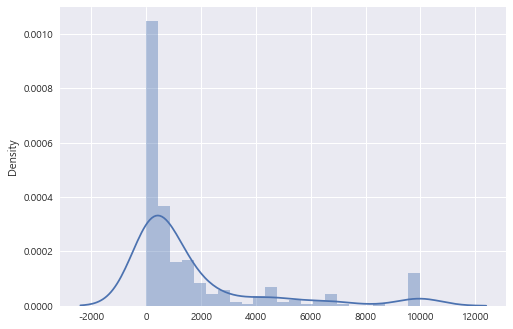

In [42]:
_ = sns.distplot(tag_counts_df)

<AxesSubplot:>

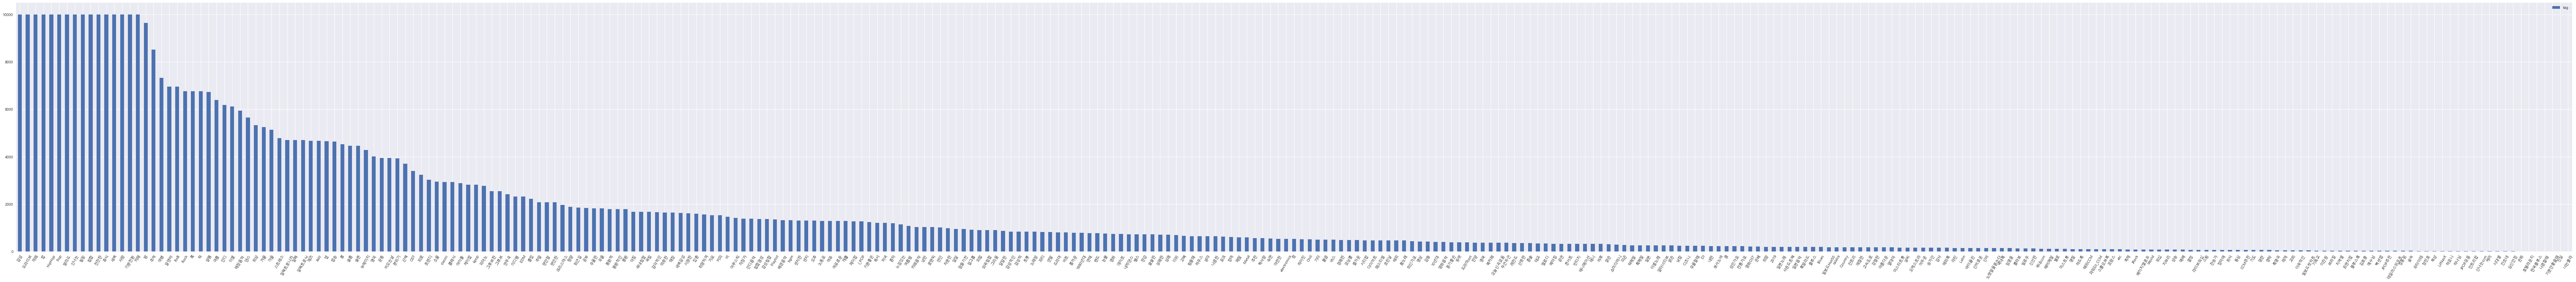

In [43]:
tag_counts_df.plot(kind='bar', figsize=(120,12), rot=60)

## playlist 곡 수집

https://www.melon.com/mymusic/dj/mymusicdjplaylistview_inform.htm?plylstSeq=511975096

In [164]:
def get_playlist_songs(plylstseq: str):
    result = {}
    playlist_url = f'https://www.melon.com/mymusic/dj/mymusicdjplaylistview_inform.htm?plylstSeq={plylstseq}'
    # Headers information    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36',
    }
    # Request - get
    response = requests.get(playlist_url, headers = headers)
    html = response.text
    # parse text by beautifullsoup
    parse = bs(html, 'html.parser')
    # find imformations
    song_txt = parse.find_all("div", "wrap_song_info", class_="ellipsis rank01")
    singer_txt = parse.find_all("div", "wrap_song_info", class_="ellipsis rank02")
    album_txt = parse.find_all("div", "wrap_song_info", class_="ellipsis rank03")

    song_code = []
    song_name = []
    singer_code = []
    singer_name = []

    for idx, song in enumerate(song_txt):
        song_code.append(song_txt[idx].find("a")['href'].split(',')[1][:-2])
        song_name.append(song_txt[idx].find("a")['title'][:-3])
        if singer_txt[idx].find("a"):
            singer_code.append(singer_txt[idx].find("a")['href'].split('\'')[1])
            singer_name.append(singer_txt[idx].find("a")['title'][:-9])
        else:
            singer_code.append('')
            singer_name.append('Various Artists')

    # make return values
    result['song_code'] = song_code
    result['song_name'] = song_name
    result['singer_code'] = singer_code
    result['singer_name'] = singer_name
    result['plylstseq'] = plylstseq

    return pd.DataFrame(result)


In [165]:
# 사용예시
songs_df = get_playlist_songs('480931922')

In [166]:
songs_df

,song_code,song_name,singer_code,singer_name,plylstseq
0,32333811,I Love Today,713743,7pm,480931922
1,31831071,Little Bird (tvN '스페인 하숙' 삽입곡),618273,물고기꿈,480931922
2,31622729,Morning Diary,38547,해리,480931922
3,8147021,새콤 달콤한 행복,944561,달빛바다,480931922
4,32227785,냥이의 숨바꼭질,943648,From Paris,480931922
5,1370395,Dance Of The Dragonfly,2078,Kevin Kern,480931922
6,32465462,Perfect Day,713920,Shizuko Mori,480931922
7,332494,Butterfly Waltz,2029,Brian Crain,480931922
8,8209025,Sunny Days,944395,서른의 꿈,480931922
9,7998989,둘이서 걷던 길,905398,레인시티 (RainCity),480931922


In [44]:
# 제목이 같은 플레이리스트 제거
all_playlist_df = all_playlist_df[~all_playlist_df['title'].duplicated()]

In [45]:
# 번호가 같은 플레이리스트 제거
all_playlist_df = all_playlist_df[~all_playlist_df['plylstSeq'].duplicated()]

In [46]:
all_playlist_list = all_playlist_df['plylstSeq'].tolist()
all_playlist_list

[506358530,
 511214436,
 506225967,
 488734201,
 464652255,
 511316969,
 512674119,
 495119848,
 511642826,
 480395232,
 503273844,
 512447118,
 501533943,
 431721556,
 500807908,
 478737263,
 512314449,
 468026902,
 499502605,
 468144064,
 512611091,
 483086564,
 457536543,
 484732185,
 422524892,
 422307578,
 421220077,
 484083307,
 499196454,
 442706386,
 100098397,
 504995932,
 503922106,
 512454641,
 512604983,
 509082861,
 456929739,
 464856973,
 512220218,
 487517318,
 511942478,
 511069733,
 480438884,
 511765826,
 481204703,
 442105804,
 511249341,
 100098227,
 508329402,
 450123206,
 489337558,
 469198716,
 460637410,
 496498480,
 483955249,
 470374673,
 431692656,
 508282971,
 513054917,
 494917123,
 509410105,
 512116975,
 512619925,
 512204385,
 501118034,
 482280210,
 466256773,
 508119613,
 460791648,
 510216907,
 497904500,
 509586776,
 478906566,
 484389614,
 498768802,
 506725249,
 457624642,
 505758699,
 512726031,
 505785411,
 463290143,
 512759838,
 468339973,
 101

In [47]:
len(all_playlist_list)

144218

In [213]:
# 모든 플레이리스트의 곡을 가져와 데이터를 parquet 파일로 저장하는 함수
def get_all_playlist_songs(plylstseq_list: list):
    batch = []
    batch_size = 10
    for k in range(batch_size):
        batch.append(plylstseq_list[k*(len(plylstseq_list)//batch_size):(k+1)*(len(plylstseq_list)//batch_size)])    
    playlist_songs_df = pd.DataFrame()
    for i, batch_list in enumerate(batch):
        for idx, plylstseq in enumerate(tqdm(batch_list)):
            if(idx == 0):
                playlist_songs_df = get_playlist_songs(plylstseq)
            else:
                playlist_songs_df = pd.concat([playlist_songs_df, get_playlist_songs(plylstseq)])
        playlist_songs_df.to_parquet(f'data/playlist_songs({len(plylstseq_list)}_{i}).parquet.gzip', compression = 'gzip', index=False)
    return playlist_songs_df

In [2]:
# 사용예시
all_songs_df = get_all_playlist_songs(all_playlist_list)

## 곡 수집

In [220]:
# load
DATA_PATH = "data"
DATA_SAVE_PATH = os.path.join(DATA_PATH, "songs_info.parquet.gzip")

class SongScrapper:
    def __init__(self):
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36",
        }

    def load(self, type="parquet"):
        if os.path.isfile(DATA_SAVE_PATH):
            return print(f"You already have the data file... ({DATA_SAVE_PATH})")

        if not os.path.isdir(DATA_PATH):
            print("Data path not found. Creating data path...")
            os.makedirs(DATA_PATH)

        files = [file_name for file_name in os.listdir(DATA_PATH) if type in file_name]
        if not files:
            return print("Data not found. you should download data first.")

        print(f"Total Data Count: {len(files)}")
        data = pd.DataFrame()
        for name in files:
            file_path = os.path.join(DATA_PATH, name)
            size = os.path.getsize(file_path)
            print(f"{name.ljust(30)}: {round(size / 1000000, 1)}MB")
            data = pd.concat([data, pd.read_parquet(file_path)])
            print(f"Current Shape: {data.shape}")
        print("\nData Loading Complete.")
        print(f"Result Shape: {data.shape}")
        return data

    def get_songs_info(self):
        data = self.load()
        if isinstance(data, pd.DataFrame):
            song_codes = data.drop_duplicates(["song_code"])["song_code"]
            print(f"\nTotal Song Count: {len(song_codes)}")
            results = pd.DataFrame()
            for i, song_code in tqdm(enumerate(song_codes)):
                result = self.get_song_info_by_code(song_code)
                results = pd.concat([results, pd.DataFrame(result, index=[i])])
            print("\nData Scrapping Complete.")
            print(f"Result Shape: {results.shape}")
            print(f"Result Columns: {results.columns}")
            results.to_parquet(DATA_SAVE_PATH, compression="gzip", index=False)

    def get_song_info_by_code(self, song_code):
        url = f"https://www.melon.com/song/lyrics.htm?songId={song_code}"
        print(url)
        response = requests.get(url, headers=self.headers)
        page = bs(response.content, "html.parser")
        artists = page.find("div", class_="artist").find_all("a", class_="artist_name")
        cover_link = page.find("a", class_="image_typeAll").find("img")["src"]
        cover_link = re.sub("/282/", "/512/", cover_link)
        cover_link = re.sub("/80/", "/100/", cover_link)
        result = {
            "song_code": song_code,
            "song_title": page.find("div", class_="song_name")
            .get_text(strip=True)
            .lstrip("곡명"),
            "artist": ", ".join([artist["title"] for artist in artists]),
            "album_cover": cover_link,
            "album_title": re.sub(
                "[\\xa0]",
                " ",
                page.find("div", class_="meta").find("a").get_text(strip=True),
            ),
            "public_date": page.find("div", class_="meta")
            .find_all("dd")[1]
            .get_text(strip=True),
            "genre": page.find("div", class_="meta")
            .find_all("dd")[2]
            .get_text(strip=True)
            .split(", ")[0],
            "lyrics": page.find(class_="wrap_lyric")
            .get_text(separator="\n", strip=True)
            .rstrip("펼치기 "),
        }

        return result


In [ ]:
SongScrapper().get_songs_info()